In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import f1_score

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle
import joblib

In [2]:
### 프로젝트 셋팅

In [3]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_new_pitcher_data_0730_1st.dat'

# 교차검증 횟수
cv_count = 10

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_macro_list = []
f1_micro_list = []

# 학습 모델 이름
model_name_list = []

In [4]:
### 데이터 준비

In [5]:
df_pit = pd.read_csv('투수_스탯_데이터_합본.csv')
df_sal_24 = pd.read_csv('24년도_선수연봉_4레벨.csv')
df_sal_25 = pd.read_csv('25년도_선수연봉_4레벨.csv')

In [6]:
# 23년 투수 데이터만 추출
df_pit_23 = df_pit[df_pit['연도'] == 2023]

# df_sal_24에서 'pid', '연봉등급' 컬럼만 남기기
df_sal_24 = df_sal_24[['pid', '연봉등급']]

# pid 기준으로 병합
df_pit_23 = pd.merge(
    df_pit_23,
    df_sal_24,
    on='pid',
    how='left'
)

In [7]:
# 24년 투수 데이터만 추출
df_pit_24 = df_pit[df_pit['연도'] == 2024]

# df_sal_25에서 'pid', '연봉등급' 컬럼만 남기기
df_sal_25 = df_sal_25[['pid', '연봉등급']]

# pid 기준으로 병합
df_pit_24 = pd.merge(
    df_pit_24,
    df_sal_25,
    on='pid',
    how='left'
)

In [8]:
# 23년 24년 데이터 병합
df_pit_all = pd.concat([df_pit_23, df_pit_24], ignore_index=True)

# 결측치 제거
df_pit_all.dropna(inplace=True)
df_pit_all.head()

,선수,G,GS,GR,GF,CG,SHO,W,L,S,...,BK,WP,ERA,FIP,WHIP,WAR,팀,pid,연도,연봉등급
0,페냐,32,32,0,0,0,0,11,11,0,...,4,16,3.60,4.06,1.17,4.28,한화 이글스,15146,2023,A
1,문동주,23,23,0,0,0,0,8,8,0,...,1,5,3.72,3.65,1.31,3.08,한화 이글스,15013,2023,B
2,산체스,24,24,0,0,0,0,7,8,0,...,0,3,3.79,3.92,1.30,2.59,한화 이글스,15643,2023,A
3,주현상,55,0,55,9,0,0,2,2,0,...,0,0,1.96,3.25,0.84,2.44,한화 이글스,11415,2023,B
4,이태양,50,12,38,6,0,0,3,3,0,...,0,1,3.23,3.60,1.21,1.78,한화 이글스,10609,2023,A


In [9]:
# 연봉 등급 인코딩
encoder1 = LabelEncoder()
y_encoded = encoder1.fit_transform(df_pit_all['연봉등급'])

In [10]:
# 입력과 결과로 나눈다.
X = df_pit_all.drop(['연봉등급', '선수', '팀', 'pid', '연도'], axis=1)
y = df_pit_all['연봉등급']

In [11]:
# train/test 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [12]:
# 표준화
scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
X_test_scaled = scaler1.transform(X_test)

In [13]:
train_X = X_train_scaled
train_y = y_train

test_X = X_test_scaled
test_y = y_test

### 기본 모델 사용하기

In [ ]:
# GradientBoost
gb_basic_model = GradientBoostingClassifier()

# 교차 검증을 수행한다
f1_macro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()


# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [15]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1)

# 교차 검증을 수행한다
f1_macro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Basic")

In [16]:
# XGBoost
xgboost_basic_model = XGBClassifier(verbose=-1, silent=True)

# 교차 검증을 수행한다
f1_macro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Basic")

In [17]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_basic_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Basic")

In [18]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_basic_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Basic")

In [19]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

,Model,F1 Macro,F1 Micro
4,SoftVoting Basic,0.542081,0.573186
1,LGBM Basic,0.538946,0.578450
3,HardVoting Basic,0.534637,0.570626
2,XGBoost Basic,0.527862,0.565292
0,GradientBoost Basic,0.526998,0.576031


### 하이퍼 파라미터 튜닝

In [20]:
# LGBM
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# LGBM 모델 정의
temp_model = LGBMClassifier(
    device='gpu',        # ✅ GPU 사용 설정
    verbose=-1,
    random_state=42
)

# f1_macro 기준으로 하이퍼파라미터 튜닝
lgbm_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
lgbm_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_lgbm_model = lgbm_grid_clf.best_estimator_

# f1_macro, f1_micro 평가
f1_macro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")

In [21]:
# XGBoost
params = {
    'booster': ['gbtree'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 모델 정의
temp_model = XGBClassifier(
    tree_method='gpu_hist',       # GPU용 학습 알고리즘
    predictor='gpu_predictor',    # GPU로 예측도 수행
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# f1_macro 기준으로 튜닝
xgboost_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
xgboost_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_xgb_model = xgboost_grid_clf.best_estimator_

# 성능 평가
f1_macro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [22]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

,Model,F1 Macro,F1 Micro
6,XGBoost Tuning,0.574931,0.626245
5,LGBM Tuning,0.545348,0.588976
4,SoftVoting Basic,0.542081,0.573186
1,LGBM Basic,0.538946,0.578450
3,HardVoting Basic,0.534637,0.570626
2,XGBoost Basic,0.527862,0.565292
0,GradientBoost Basic,0.526998,0.576031


### 혼동 행렬 그리기

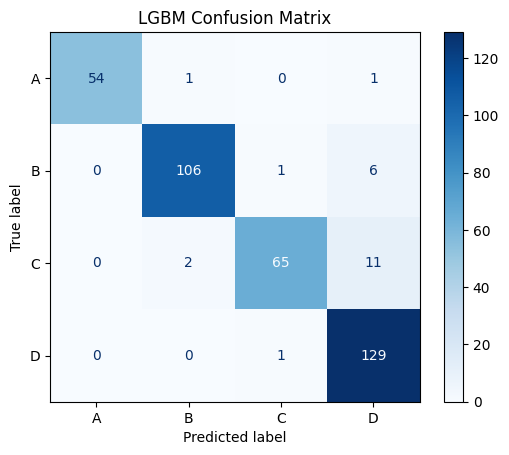

In [30]:
# LGBM
best_lgbm_model.fit(train_X, train_y)
y_pred = best_lgbm_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D'])
disp.plot(cmap='Blues')
plt.title("LGBM Confusion Matrix")
plt.show()

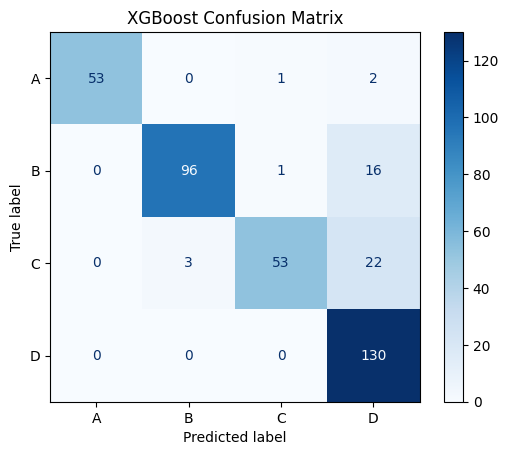

In [31]:
# XGBoost
best_xgb_model.fit(train_X, train_y)
y_pred = best_xgb_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D'])
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

In [25]:
10/0

ZeroDivisionError: division by zero

In [26]:
# 최종 모델을 생성하고 전체 데이터를 학습 시킨다.
best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
best_model.set_params(**xgboost_grid_clf.best_params_)
best_model.fit(train_X, train_y)
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
# 학습 모델 등을 저장한다.
save_objects = {
    'model': best_model,
    'encoder': encoder1,   # ← 존재할 경우만
    'scaler': scaler1      # ← 존재할 경우만
}

with open(best_model_path, 'wb') as fp:
    pickle.dump(save_objects, fp)

In [28]:
# 저장 확인
# 불러오기
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

# 추출
test_model = loaded['model']
test_encoder = loaded.get('encoder')  # 없는 경우 None
test_scaler = loaded.get('scaler')

In [29]:
r1 = test_model.predict(train_X)
r2 = f1_score(train_y, r1, average='macro')  # 또는 'micro'
print("F1 Macro:", r2)

F1 Macro: 0.8884182020559275
